In [15]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from datetime import datetime
import numpy as np
import math
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
import plotly.express as px

In [16]:
data = pd.read_excel('5years_database.xlsx', sheet_name='Data with Vix')
data

,Date,Sp-close,Volume,Vix-close
0,02/22/2023,3991.05,4079320000,22.29
1,02/21/2023,3997.34,4121590000,22.87
2,02/17/2023,4079.09,4045480000,20.02
3,02/16/2023,4090.41,4143660000,20.17
4,02/15/2023,4147.60,4075980000,18.23
...,...,...,...,...
1163,07/09/2018,2784.17,3070060000,12.69
1164,07/06/2018,2759.82,2590250000,13.37
1165,07/05/2018,2736.61,2980160000,14.97
1166,07/03/2018,2713.22,1911460000,16.14


In [17]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y') 

In [18]:
trading_instrument = 'Sp-close'
fig = px.line(data, x='Date', y='Sp-close', title=f'{trading_instrument} Time Series')
fig.show()

In [19]:
# Normalize the Close column using min-max scaling
scaler = MinMaxScaler()    #x' = (x - min) / (max - min) Normalization
normalized_columns = ["Norm_Volume", "Norm_Vix_close", "Norm_Sp_close"]
data.dropna(inplace=True)
data[normalized_columns] = scaler.fit_transform(data[["Volume", "Vix-close", "Sp-close"]])
data

,Date,Sp-close,Volume,Vix-close,Norm_Volume,Norm_Vix_close,Norm_Sp_close
0,2023-02-22,3991.05,4079320000,22.29,0.320598,0.159243,0.685244
1,2023-02-21,3997.34,4121590000,22.87,0.325468,0.167316,0.687702
2,2023-02-17,4079.09,4045480000,20.02,0.316700,0.127645,0.719646
3,2023-02-16,4090.41,4143660000,20.17,0.328011,0.129733,0.724070
4,2023-02-15,4147.60,4075980000,18.23,0.320214,0.102728,0.746417
...,...,...,...,...,...,...,...
1163,2018-07-09,2784.17,3070060000,12.69,0.204324,0.025612,0.213652
1164,2018-07-06,2759.82,2590250000,13.37,0.149046,0.035078,0.204137
1165,2018-07-05,2736.61,2980160000,14.97,0.193967,0.057350,0.195068
1166,2018-07-03,2713.22,1911460000,16.14,0.070845,0.073636,0.185928


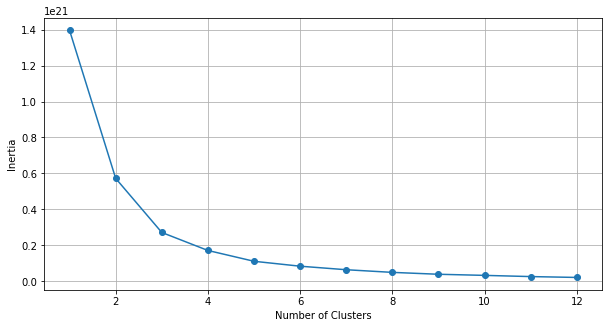

In [20]:
def optimise_k_means(dt, max_k):
    means=[] #the number of clusters used for each model
    inertias=[] #sum of squared distances of samples to their closest cluster center for each model
    for k in range(1, max_k):
        kmeans =  KMeans(n_clusters=k)
        kmeans.fit(dt)

        means.append(k)
        inertias.append(kmeans.inertia_)
        
    #generate the elbow plot
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()
optimise_k_means(data[["Sp-close", "Volume", "Vix-close"]],13)

Perform K-means clustering

In [21]:
kmeans = KMeans(n_clusters=3, random_state=7)
data['kmeans_3'] = kmeans.fit_predict(data[normalized_columns])
data.head(5)

,Date,Sp-close,Volume,Vix-close,Norm_Volume,Norm_Vix_close,Norm_Sp_close,kmeans_3
0,2023-02-22,3991.05,4079320000,22.29,0.320598,0.159243,0.685244,2
1,2023-02-21,3997.34,4121590000,22.87,0.325468,0.167316,0.687702,2
2,2023-02-17,4079.09,4045480000,20.02,0.316700,0.127645,0.719646,2
3,2023-02-16,4090.41,4143660000,20.17,0.328011,0.129733,0.724070,2
4,2023-02-15,4147.60,4075980000,18.23,0.320214,0.102728,0.746417,2


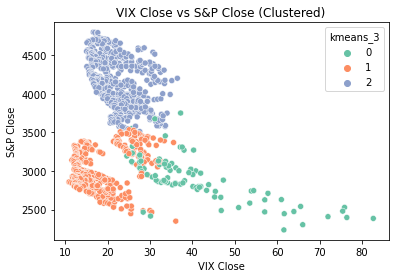

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=data['Vix-close'], y=data['Sp-close'], hue=data['kmeans_3'], palette='Set2')
plt.xlabel('VIX Close')
plt.ylabel('S&P Close')
plt.title('VIX Close vs S&P Close (Clustered)')
plt.show()

In [23]:
#Calculate the mean values of each feature within each cluster
centroids = data.groupby('kmeans_3').mean()
print(centroids)

             Sp-close        Volume  Vix-close  Norm_Volume  Norm_Vix_close  \
kmeans_3                                                                      
0         2894.023295  6.436732e+09  40.763068     0.592190        0.416385   
1         2981.044229  3.692418e+09  17.796759     0.276024        0.096698   
2         4141.473049  4.483430e+09  22.451847     0.367155        0.161496   

          Norm_Sp_close  
kmeans_3                 
0              0.256578  
1              0.290581  
2              0.744023  


In [24]:
# Calculate returns
data['Sp-returns'] = data['Sp-close'].pct_change()
data.dropna(inplace=True)


In [27]:
cluster_stats = data.groupby('kmeans_3')['Sp-returns'].agg(['mean', 'count'])
cluster_stats['positive_returns'] = (data[data['Sp-returns'] > 0]
                                     .groupby('kmeans_3')['Sp-returns'].count())
cluster_stats['negative_returns'] = (data[data['Sp-returns'] < 0]
                                     .groupby('kmeans_3')['Sp-returns'].count())

# add new label column based on number of positive returns
cluster_stats['label'] = np.where(cluster_stats['positive_returns'] > cluster_stats['negative_returns'], 'Bullish', 'Bearish')


In [28]:
print(cluster_stats)

              mean  count  positive_returns  negative_returns    label
kmeans_3                                                              
0         0.000569     88                42                46  Bearish
1        -0.000585    506               215               291  Bearish
2        -0.000033    573               287               286  Bullish


In [29]:
market_regime_map = {
  0: 'High-volatility',
  1: 'Low-volatility',
  2: 'Average-volatility',

}

data['Market Regime'] = data['kmeans_3'].map(market_regime_map)
data

,Date,Sp-close,Volume,Vix-close,Norm_Volume,Norm_Vix_close,Norm_Sp_close,kmeans_3,Sp-returns,Market Regime
1,2023-02-21,3997.34,4121590000,22.87,0.325468,0.167316,0.687702,2,0.001576,Average-volatility
2,2023-02-17,4079.09,4045480000,20.02,0.316700,0.127645,0.719646,2,0.020451,Average-volatility
3,2023-02-16,4090.41,4143660000,20.17,0.328011,0.129733,0.724070,2,0.002775,Average-volatility
4,2023-02-15,4147.60,4075980000,18.23,0.320214,0.102728,0.746417,2,0.013981,Average-volatility
5,2023-02-14,4136.13,3929200000,18.91,0.303303,0.112194,0.741935,2,-0.002765,Average-volatility
...,...,...,...,...,...,...,...,...,...,...
1163,2018-07-09,2784.17,3070060000,12.69,0.204324,0.025612,0.213652,1,-0.003461,Low-volatility
1164,2018-07-06,2759.82,2590250000,13.37,0.149046,0.035078,0.204137,1,-0.008746,Low-volatility
1165,2018-07-05,2736.61,2980160000,14.97,0.193967,0.057350,0.195068,1,-0.008410,Low-volatility
1166,2018-07-03,2713.22,1911460000,16.14,0.070845,0.073636,0.185928,1,-0.008547,Low-volatility


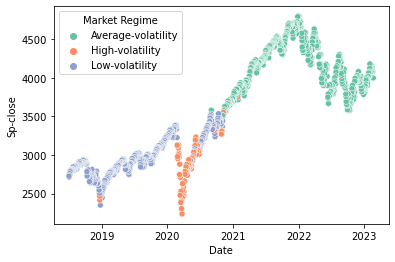

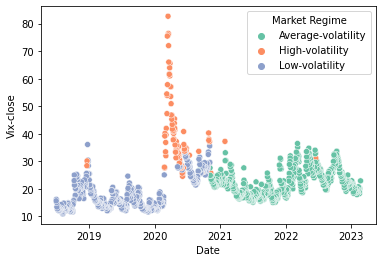

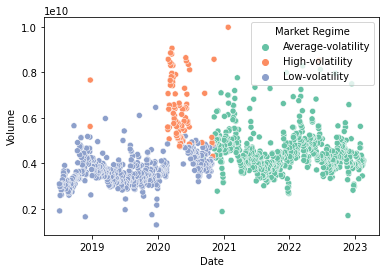

In [30]:
#S&P close
sns.scatterplot(x=data['Date'], y=data['Sp-close'], hue=data['Market Regime'], palette='Set2')
plt.show()

#VIX Index
sns.scatterplot(x=data['Date'], y=data['Vix-close'], hue=data['Market Regime'], palette='Set2')
plt.show()

#s&p volume
sns.scatterplot(x=data['Date'], y=data['Volume'], hue=data['Market Regime'], palette='Set2')
plt.show()

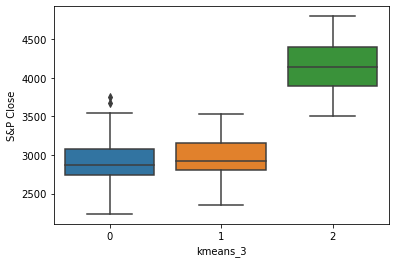

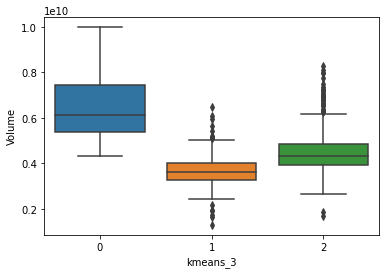

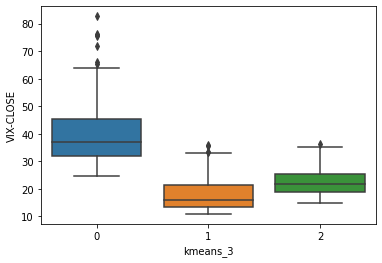

In [32]:
sns.boxplot(x='kmeans_3', y='Sp-close', data=data)
plt.ylabel('S&P Close')
plt.show()

sns.boxplot(x='kmeans_3', y='Volume', data=data)
plt.ylabel('Volume')
plt.show()

sns.boxplot(x='kmeans_3', y='Vix-close', data=data)
plt.ylabel('VIX-CLOSE')
plt.show()